<a href="https://colab.research.google.com/github/med-fakil/ML-AMCHD-/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 6.6 MB/s 
     |████████████████████████████████| 1.6 MB 47.9 MB/s 


In [4]:
import tensorflow as tf
import splitfolders

from kerastuner.tuners import RandomSearch
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
# graph
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# matrice de conf
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import pathlib
import os
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers

<ipython-input-4-4e8efc5d7426>:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


### Load & Extract Data

In [5]:
data_dir = '/content/drive/MyDrive/archive.zip'
import zipfile
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')

In [6]:
data_dir = pathlib.Path('/content/datasets/AMHCD_64/AMHCD_64')
print("Le répertoire de données : {} ".format(data_dir))

Le répertoire de données : /content/datasets/AMHCD_64/AMHCD_64 


In [7]:
image_count = len(list(data_dir.glob('*/*')))
print("Nombre des images de la base de données : {} ".format(image_count))

Nombre des images de la base de données : 25740 


In [ ]:
image = plt.imread("/content/datasets/AMHCD_64/AMHCD_64/yadd/yadd_1.jpeg")

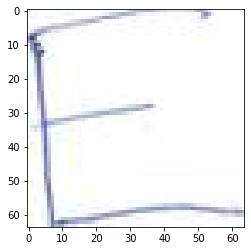

In [ ]:
plt.imshow(image)

In [ ]:
image.shape

(64, 64, 3)

### Data Spit

In [8]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
#56.03 13.97 30
input_folder="/content/datasets/AMHCD_64/AMHCD_64/"
splitfolders.ratio(input_folder, output="/content/outputimages",
                   ratio=(.56,.14,.3),
                   group_prefix=None)

Copying files: 25740 files [00:03, 6981.40 files/s]


In [13]:
image_width=60
image_height=60

### RGB

In [14]:
# train_data est un objet tensor, chaque élement est un tuple (image,label) 
fdata="/content/outputimages/train"
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  fdata,
  #shuffle=True,
  label_mode='categorical',
  image_size=(image_width, image_height),
  #batch_size=batch_size,
  )

Found 14388 files belonging to 33 classes.


In [15]:
# train_data est un objet tensor, chaque élement est un tuple (image,label) 
ffdata="/content/outputimages/test"
test_data = tf.keras.preprocessing.image_dataset_from_directory(
  ffdata,
  #shuffle=True,
  label_mode='categorical',
  image_size=(image_width, image_height),
  #batch_size=batch_size,
  )

Found 7755 files belonging to 33 classes.


In [16]:
# train_data est un objet tensor, chaque élement est un tuple (image,label) 
fffdata="/content/outputimages/val"
val_data = tf.keras.preprocessing.image_dataset_from_directory(
  fffdata,
  #shuffle=True,
  label_mode='categorical',
  image_size=(image_width, image_height),
  #batch_size=batch_size,
  )

Found 3597 files belonging to 33 classes.


### binary

In [ ]:
fdata="/content/outputimages/train"
train_data_binary = tf.keras.preprocessing.image_dataset_from_directory(
  fdata,
  #shuffle=True,
  label_mode='categorical',
  color_mode='grayscale',
  image_size=(image_width, image_height),
  #batch_size=batch_size,
  )
ffdata="/content/outputimages/test"
test_data_binary = tf.keras.preprocessing.image_dataset_from_directory(
  ffdata,
  #shuffle=True,
  label_mode='categorical',
  color_mode='grayscale',
  image_size=(image_width, image_height),
  #batch_size=batch_size,
  )
fffdata="/content/outputimages/val"
val_data_binary = tf.keras.preprocessing.image_dataset_from_directory(
  fffdata,
  #shuffle=True,
  label_mode='categorical',
  color_mode='grayscale',
  image_size=(image_width, image_height),
  #batch_size=batch_size,
  )

Found 14388 files belonging to 33 classes.
Found 7755 files belonging to 33 classes.
Found 3597 files belonging to 33 classes.


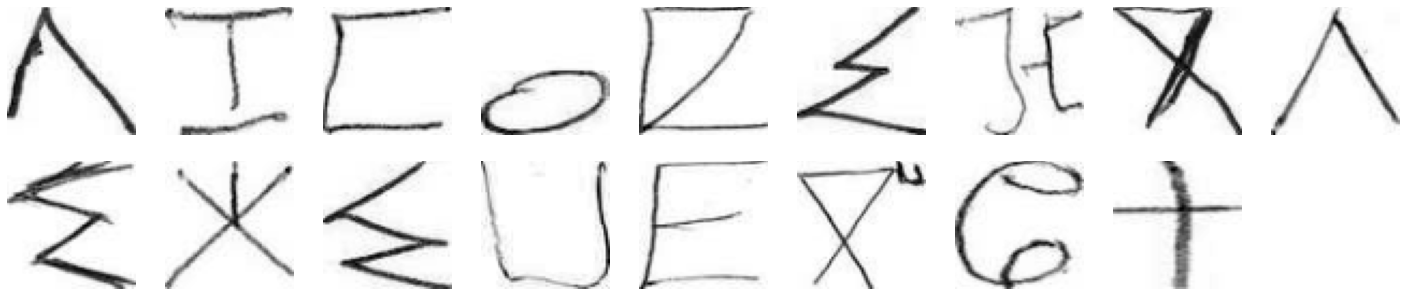

In [ ]:
# visualize first 9
plt.figure(figsize=(25, 25))
for images, labels in train_data_binary.take(1):
  for i in range(17):
    ax = plt.subplot(9, 9, i + 1)
    img=images[i].numpy().astype("uint8")
    plt.imshow(img[:,:,0],cmap='gray')
    dim=np.array(images[i]).shape
    dim=" ("+str(dim[0]) +","+ str(dim[1]) +","+ str(dim[2]) +")"
    plt.axis("off")


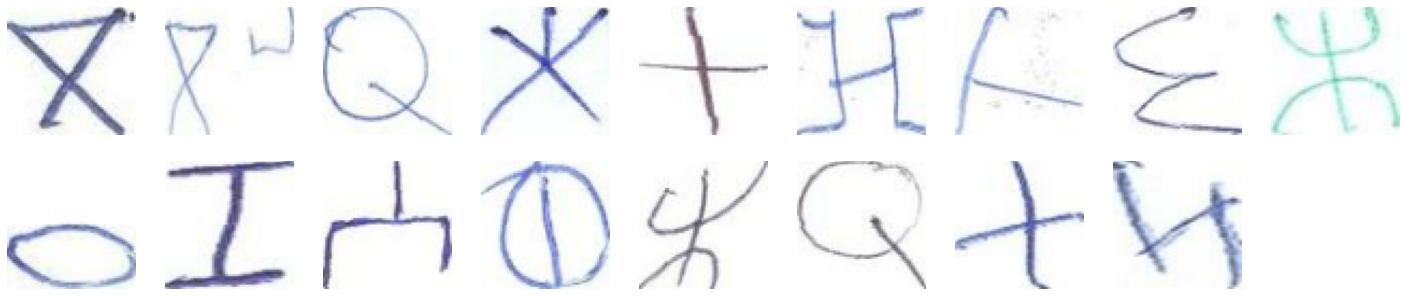

In [ ]:
plt.figure(figsize=(25, 25))
for images, labels in train_data.take(1):
    for i in range(17):
      ax = plt.subplot(9, 9, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      dim=np.array(images[i]).shape
      dim=" ("+str(dim[0]) +","+ str(dim[1]) +","+ str(dim[2]) +")"
      plt.axis("off")


### Models creation

### MODEL RGB

In [ ]:
num_classes=33
model = Sequential()
#model.add(Rescaling(1./255))
model.add(Conv2D(20, kernel_size=(5, 5),padding="same",strides = 2, input_shape=(60, 60, 3)))
#model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2),strides = 2))
#model.add(Dropout(rate=0.5)),

model.add(Conv2D(16, kernel_size=(3, 3),padding="same",strides = 2))
#model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2),strides = 2))
#model.add(Dropout(rate=0.5)),

model.add(Conv2D(60, kernel_size=(3, 3),padding="same",strides = 2))
#model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2),strides = 2))
model.add(Dropout(rate=0.5))

#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
#model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))
#model.add(Dropout(rate=0.5))


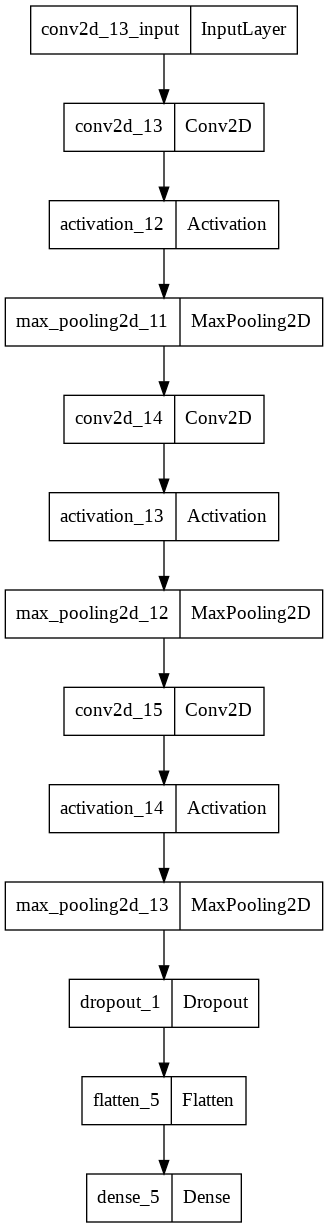

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

logdir="logs"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
                                                   histogram_freq=1, 
                                                   write_images=logdir,
                                                   embeddings_data=train_data)


historique = model.fit( 
             train_data,
             validation_data=val_data,
             #batch_size=64,
             epochs=40,
             callbacks=[tensorboard_callback]
)

Epoch 1/40
450/450 [==============================] - 23s 49ms/step - loss: 4.5751 - accuracy: 0.0299 - val_loss: 3.4887 - val_accuracy: 0.0353
Epoch 2/40
450/450 [==============================] - 22s 48ms/step - loss: 3.4758 - accuracy: 0.0427 - val_loss: 3.4010 - val_accuracy: 0.0584
Epoch 3/40
450/450 [==============================] - 24s 53ms/step - loss: 3.4118 - accuracy: 0.0564 - val_loss: 3.2943 - val_accuracy: 0.0826
Epoch 4/40
450/450 [==============================] - 22s 49ms/step - loss: 3.2014 - accuracy: 0.0846 - val_loss: 3.1180 - val_accuracy: 0.1090
Epoch 5/40
450/450 [==============================] - 22s 49ms/step - loss: 2.9454 - accuracy: 0.1316 - val_loss: 2.6553 - val_accuracy: 0.2032
Epoch 6/40
450/450 [==============================] - 22s 49ms/step - loss: 2.7414 - accuracy: 0.1674 - val_loss: 2.4090 - val_accuracy: 0.2602
Epoch 7/40
450/450 [==============================] - 23s 50ms/step - loss: 2.6209 - accuracy: 0.1890 - val_loss: 2.4423 - val_accuracy:

In [ ]:
model.save('/content/drive/MyDrive/Article2_test_model1/modelVF.h5')

In [ ]:
model.evaluate(val_data)

113/113 [==============================] - 4s 34ms/step - loss: 0.3079 - accuracy: 0.9502


[0.3079245090484619, 0.9502363204956055]

In [ ]:
import pandas as pd
metrics = pd.DataFrame(historique.history)

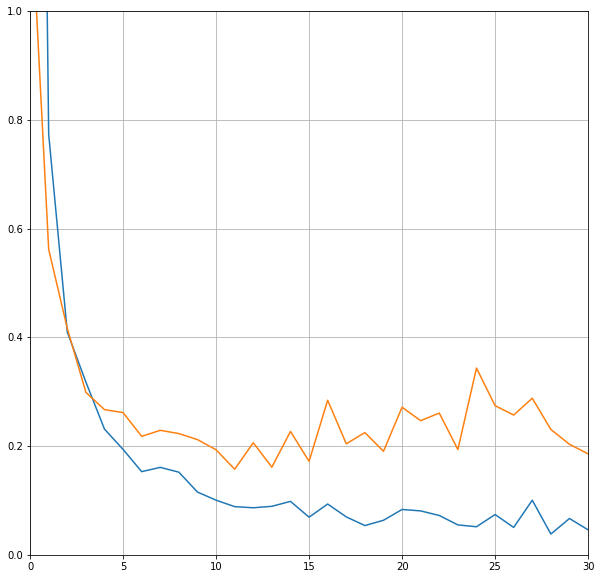

In [ ]:
plt.figure(figsize=(10,10))
plt.ylim([0,1])
plt.xlim([0,30])
plt.plot(metrics[["loss","val_loss"]])
plt.grid(True)
plt.show()

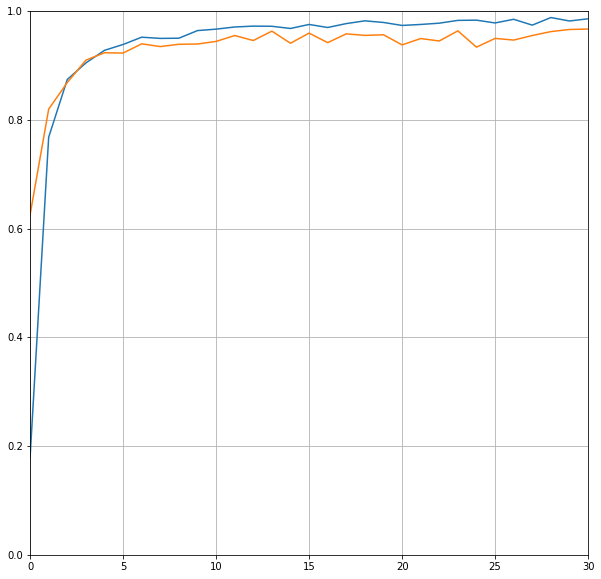

In [ ]:
plt.figure(figsize=(10,10))
plt.ylim([0,1])
plt.xlim([0,30])
plt.plot(metrics[["accuracy","val_accuracy"]])
plt.grid(True)
plt.show()

### MODEL BINARY

In [ ]:
num_classes=33
modelBN = Sequential()
modelBN.add(Conv2D(20, kernel_size=(5, 5),padding="same",strides = 2, input_shape=(60, 60, 1)))
#modelBN.add(BatchNormalization())
modelBN.add(Activation("relu"))
modelBN.add(MaxPooling2D(pool_size=(2, 2),padding="same",strides = 2))
#model.add(Dropout(rate=0.5))

modelBN.add(Conv2D(16, kernel_size=(3, 3),padding="same",strides = 2))
#modelBN.add(BatchNormalization())
modelBN.add(Activation("relu"))
modelBN.add(MaxPooling2D(pool_size=(2, 2),padding="same",strides = 2))
#model.add(Dropout(rate=0.5))

modelBN.add(Conv2D(60, kernel_size=(3, 3),padding="same",strides = 2))
#modelBN.add(BatchNormalization())
modelBN.add(Activation("relu"))
#modelBN.add(Dropout(rate=0.5))

#model.add(MaxPooling2D(pool_size=(2, 2)))
modelBN.add(Flatten())
#modelBN.add(BatchNormalization())
modelBN.add(Dense(num_classes, activation='softmax'))


In [ ]:
modelBN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

logdir="logs"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
                                                   histogram_freq=1, 
                                                   write_images=logdir,
                                                   embeddings_data=train_data_binary)


historique = modelBN.fit( 
             train_data_binary,
             validation_data=val_data_binary,
             epochs=30,
             callbacks=[tensorboard_callback]
)

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


450/450 [==============================] - 19s 41ms/step - loss: 1.8948 - accuracy: 0.5544 - val_loss: 0.5697 - val_accuracy: 0.8274
Epoch 2/30
450/450 [==============================] - 19s 42ms/step - loss: 0.4399 - accuracy: 0.8663 - val_loss: 0.4374 - val_accuracy: 0.8668
Epoch 3/30
450/450 [==============================] - 19s 42ms/step - loss: 0.2937 - accuracy: 0.9124 - val_loss: 0.2617 - val_accuracy: 0.9183
Epoch 4/30
450/450 [==============================] - 19s 41ms/step - loss: 0.2129 - accuracy: 0.9331 - val_loss: 0.2078 - val_accuracy: 0.9341
Epoch 5/30
450/450 [==============================] - 23s 50ms/step - loss: 0.1896 - accuracy: 0.9411 - val_loss: 0.2367 - val_accuracy: 0.9283
Epoch 6/30
450/450 [==============================] - 19s 41ms/step - loss: 0.1738 - accuracy: 0.9427 - val_loss: 0.1906 - val_accuracy: 0.9422
Epoch 7/30
450/450 [==============================] - 19s 43ms/step - loss: 0.1288 - accuracy: 0.9584 - val_loss: 0.2552 - val_accuracy: 0.9199
Epo

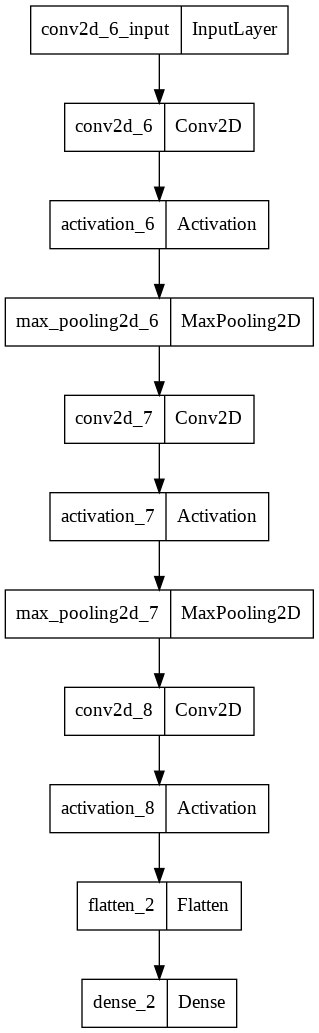

In [ ]:
tf.keras.utils.plot_model(
    modelBN,
    to_file="modelbn.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [ ]:
modelBN.save('/content/drive/MyDrive/Article2_test_model1/model_bnVF.h5')

In [ ]:
modelBN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 20)        520       
                                                                 
 activation_6 (Activation)   (None, 30, 30, 20)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 20)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 16)          2896      
                                                                 
 activation_7 (Activation)   (None, 8, 8, 16)          0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                  

In [ ]:
modelBN.evaluate(val_data_binary)

113/113 [==============================] - 3s 28ms/step - loss: 0.1918 - accuracy: 0.9694


[0.19177909195423126, 0.9694189429283142]

In [ ]:
import pandas as pd
metrics = pd.DataFrame(historique.history)

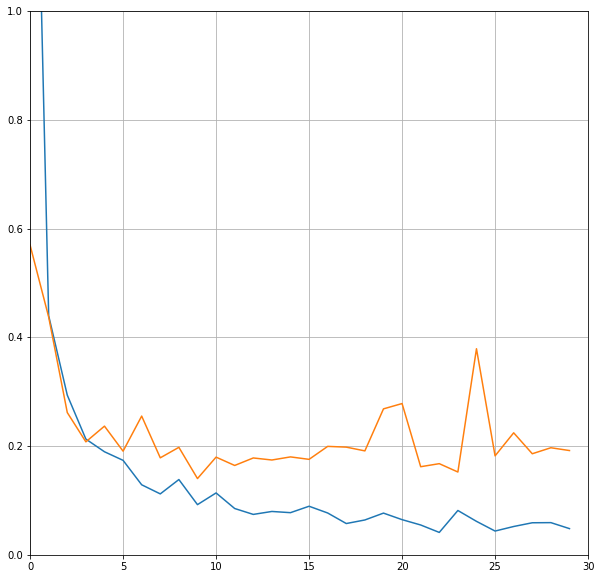

In [ ]:
plt.figure(figsize=(10,10))
plt.ylim([0,1])
plt.xlim([0,30])
plt.plot(metrics[["loss","val_loss"]])
plt.grid(True)
plt.show()

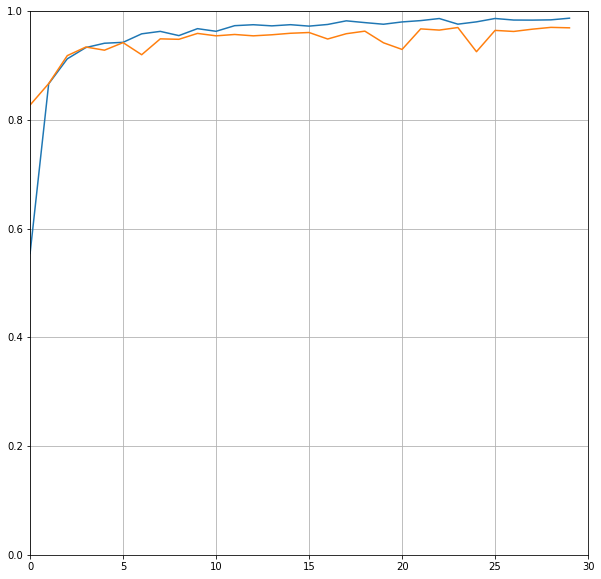

In [ ]:
plt.figure(figsize=(10,10))
plt.ylim([0,1])
plt.xlim([0,30])
plt.plot(metrics[["accuracy","val_accuracy"]])
plt.grid(True)
plt.show()

### Data augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        '/content/outputimages/train',
        target_size=(60, 60),
        batch_size=32,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        '/content/outputimages/val',
        target_size=(60, 600),
        batch_size=32,
        class_mode='categorical')
model.fit(
        train_generator,
        steps_per_epoch=2000,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800)

Found 14388 images belonging to 33 classes.
Found 3597 images belonging to 33 classes.
Epoch 1/50
 450/2000 [=====>........................] - ETA: 2:00 - loss: 3.3576 - accuracy: 0.0747

2000/2000 [==============================] - 36s 18ms/step - loss: 3.3576 - accuracy: 0.0747 - val_loss: 2.5330 - val_accuracy: 0.3280


In [ ]:

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Tunning

In [ ]:
#--------------------------------------------------------------------------------------------------------------#

In [17]:
def build(hp) : 
        model = keras.Sequential()
        model.add(layers.Input( (60,60,3)))
        # Whether to include normalization layer
        if hp.Boolean("normalize"):
            model.add(layers.Normalization())
        
        drop_rate = hp.Float("drop_rate", min_value=0.05, max_value=0.5, step=0.10)
        # Number of Conv Layers is up to tuning
        for i in range( hp.Int("num_conv", min_value=1, max_value=5, step=1)) :
            # Tune hyperparams of each conv layer separately by using f"...{i}"
            model.add(layers.Conv2D(filters=hp.Int(name=f"filters_{i}", min_value=16, max_value=60, step=10),
                                    kernel_size= hp.Int(name=f"kernel_{i}", min_value=3, max_value=7, step=2),
                                    strides=2, padding='same',
                                    activation="relu"))
            # Batch Norm and Dropout layers as hyperparameters to be searched
            if hp.Boolean("batch_norm"):
                model.add(layers.BatchNormalization())
            if hp.Boolean("dropout"):
                model.add(layers.Dropout(drop_rate))

        model.add(layers.Flatten())
        for i in range(hp.Int("num_dense", min_value=1, max_value=3, step=1)) :
            model.add(layers.Dense(units=hp.Choice("neurons", [150, 200]),
                                       activation=hp.Choice("mlp_activ", ['sigmoid', 'relu'])))
            if hp.Boolean("batch_norm"):
                    model.add(layers.BatchNormalization())
            if hp.Boolean("dropout"):
                    model.add(layers.Dropout(drop_rate))
        
        # Last layer
        model.add(layers.Dense(33, activation='softmax'))
        
        # Picking an opimizer and a loss function
        model.compile(optimizer=hp.Choice('optim',['adam','adamax',"rmsprop"]),
                      loss=hp.Choice("loss",["categorical_crossentropy","kl_divergence"]),
                      metrics = ['accuracy'])
        
        # A way to optimize the learning rate while also trying different optimizers
        learning_rate = hp.Choice('lr', [ 0.03, 0.01, 0.003])
        K.set_value(model.optimizer.learning_rate, learning_rate)
        
        return model
    

In [18]:
tuner = RandomSearch( build,
                      max_trials=5,  # how many model variations to test?
                      objective = "val_accuracy",
                      executions_per_trial=3,  # how many trials per variation? (same model could perform differently)
                      )

In [19]:
tuner.search(x=train_data,epochs=20,validation_data = val_data)

Trial 5 Complete [00h 09m 20s]
val_accuracy: 0.03030303120613098

Best val_accuracy So Far: 0.986748198668162
Total elapsed time: 00h 46m 04s


In [20]:
from tensorflow.keras.utils import plot_model
# Get the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(1)[0]

# get the best model
best_model = tuner.get_best_models(1)[0]

In [21]:
print(tuner.get_best_hyperparameters()[0].values)

{'normalize': False, 'drop_rate': 0.45000000000000007, 'num_conv': 4, 'filters_0': 56, 'kernel_0': 5, 'batch_norm': True, 'dropout': False, 'num_dense': 1, 'neurons': 200, 'mlp_activ': 'sigmoid', 'optim': 'adam', 'loss': 'kl_divergence', 'lr': 0.003, 'filters_1': 46, 'kernel_1': 5, 'filters_2': 16, 'kernel_2': 5, 'filters_3': 46, 'kernel_3': 3, 'filters_4': 16, 'kernel_4': 3}


In [23]:

# Build the model with the optimal hyperparameters
# train the model.
model = tuner.hypermodel.build(best_hps)
historique = model.fit(train_data, 
          validation_data=val_data, 
          epochs= 40)

Epoch 1/40
450/450 [==============================] - 10s 19ms/step - loss: 0.3167 - accuracy: 0.9115 - val_loss: 2.8964 - val_accuracy: 0.4743
Epoch 2/40
450/450 [==============================] - 8s 17ms/step - loss: 0.0831 - accuracy: 0.9738 - val_loss: 1.6158 - val_accuracy: 0.6870
Epoch 3/40
450/450 [==============================] - 8s 17ms/step - loss: 0.0580 - accuracy: 0.9821 - val_loss: 2.6671 - val_accuracy: 0.5152
Epoch 4/40
450/450 [==============================] - 8s 18ms/step - loss: 0.0339 - accuracy: 0.9900 - val_loss: 2.4030 - val_accuracy: 0.5443
Epoch 5/40
450/450 [==============================] - 8s 17ms/step - loss: 0.0344 - accuracy: 0.9894 - val_loss: 1.1143 - val_accuracy: 0.7884
Epoch 6/40
450/450 [==============================] - 8s 18ms/step - loss: 0.0372 - accuracy: 0.9885 - val_loss: 0.1416 - val_accuracy: 0.9616
Epoch 7/40
450/450 [==============================] - 9s 20ms/step - loss: 0.0345 - accuracy: 0.9887 - val_loss: 2.2932 - val_accuracy: 0.681

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 56)        4256      
                                                                 
 batch_normalization_5 (Batc  (None, 30, 30, 56)       224       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 15, 15, 46)        64446     
                                                                 
 batch_normalization_6 (Batc  (None, 15, 15, 46)       184       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 16)          18416     
                                                                 
 batch_normalization_7 (Batc  (None, 8, 8, 16)        

In [25]:
import pandas as pd
metrics = pd.DataFrame(historique.history)

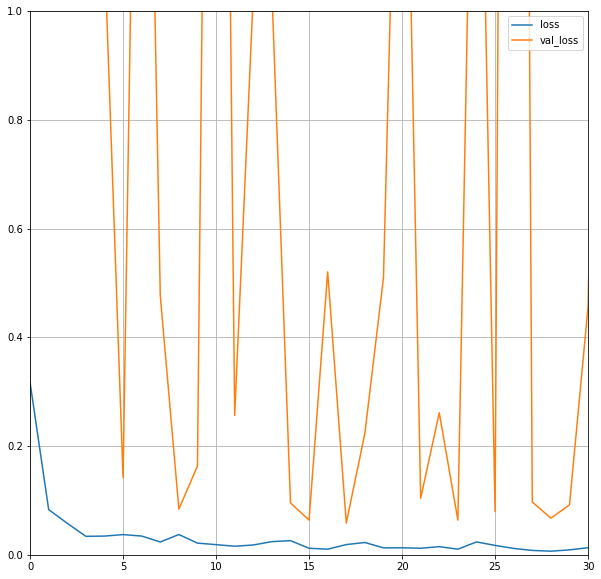

In [26]:
plt.figure(figsize=(10,10))
plt.ylim([0,1])
plt.xlim([0,30])
plt.plot(metrics[["loss"]],label = "loss")
plt.plot(metrics[["val_loss"]],label="val_loss")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

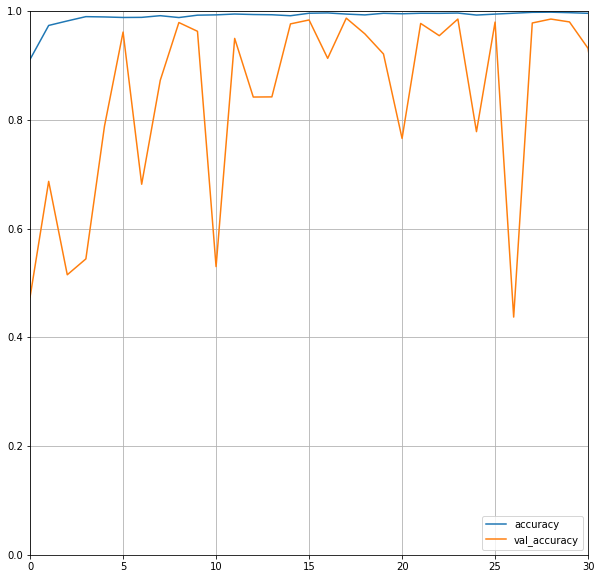

In [27]:
plt.figure(figsize=(10,10))
plt.ylim([0,1])
plt.xlim([0,30])
plt.plot(metrics[["accuracy"]],label = "accuracy")
plt.plot(metrics[["val_accuracy"]],label="val_accuracy")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [28]:
model.evaluate(test_data)

243/243 [==============================] - 4s 15ms/step - loss: 4.7980 - accuracy: 0.5146


[4.798033237457275, 0.5146357417106628]